In [40]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import numpy as np


In [2]:
data = pd.read_csv("data/HIV.csv")

In [3]:
data['HIV_active'].value_counts()

0    39684
1     1443
Name: HIV_active, dtype: int64

In [4]:
from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles', molCol='Molecule')
data.head()

[08:57:20] Explicit valence for atom # 3 Al, 6, is greater than permitted
[08:57:21] Explicit valence for atom # 5 B, 5, is greater than permitted
[08:57:22] Explicit valence for atom # 16 Al, 9, is greater than permitted
[08:57:22] Explicit valence for atom # 4 Al, 9, is greater than permitted
[08:57:24] Explicit valence for atom # 12 Al, 7, is greater than permitted
[08:57:24] Explicit valence for atom # 13 Al, 7, is greater than permitted
[08:57:24] WARNING: not removing hydrogen atom without neighbors
[08:57:24] WARNING: not removing hydrogen atom without neighbors
[08:57:24] Explicit valence for atom # 6 Ge, 5, is greater than permitted


,smiles,activity,HIV_active,Molecule
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x14d2a17e0>
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x14d2a1af0>
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,<rdkit.Chem.rdchem.Mol object at 0x14d343290>
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,<rdkit.Chem.rdchem.Mol object at 0x14d343300>
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,<rdkit.Chem.rdchem.Mol object at 0x14d343370>


In [5]:
from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

217
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x30b099ea0>), ('MaxEStateIndex', <function MaxEStateIndex at 0x30b099d80>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x30b099f30>), ('MinEStateIndex', <function MinEStateIndex at 0x30b099e10>), ('qed', <function qed at 0x30b0e4b80>)]


In [6]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res
        

In [7]:
getMolDescriptors(data['Molecule'][0])

{'MaxAbsEStateIndex': 5.925902777777779,
 'MaxEStateIndex': 5.925902777777779,
 'MinAbsEStateIndex': 0.759994212962963,
 'MinEStateIndex': -2.3300115740740743,
 'qed': 0.4343577626448334,
 'SPS': 23.36842105263158,
 'MolWt': 319.8880000000001,
 'HeavyAtomMolWt': 295.696,
 'ExactMolWt': 319.09650816808994,
 'NumValenceElectrons': 114,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': nan,
 'MinPartialCharge': nan,
 'MaxAbsPartialCharge': nan,
 'MinAbsPartialCharge': nan,
 'FpDensityMorgan1': 0.631578947368421,
 'FpDensityMorgan2': 0.8947368421052632,
 'FpDensityMorgan3': 1.105263157894737,
 'BCUT2D_MWHI': nan,
 'BCUT2D_MWLOW': nan,
 'BCUT2D_CHGHI': nan,
 'BCUT2D_CHGLO': nan,
 'BCUT2D_LOGPHI': nan,
 'BCUT2D_LOGPLOW': nan,
 'BCUT2D_MRHI': nan,
 'BCUT2D_MRLOW': nan,
 'AvgIpc': 2.4519284393308696,
 'BalabanJ': 2.470867093556556,
 'BertzCT': 386.3278612823769,
 'Chi0': 13.880468888623982,
 'Chi0n': 12.177145193552503,
 'Chi0v': 13.11879696999086,
 'Chi1': 9.141620172685641,
 'Chi1n': 6.9657167

In [ ]:
_data = data
features = [getMolDescriptors(mol) for mol in _data['Molecule']]

In [119]:
featured_df = pd.DataFrame(features)
featured_df['y'] = _data['HIV_active'].values
featured_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,y
0,5.925903,5.925903,0.759994,-2.330012,0.434358,23.368421,319.888,295.696,319.096508,114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6.515117,6.515117,0.475558,-2.879653,0.104103,20.717949,564.140,535.916,563.127808,198.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,12.177015,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,278.271,291.071785,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,11.401803,11.401803,0.087790,-4.524487,0.357615,12.583333,370.408,356.296,370.029328,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,9.857917,9.857917,0.980324,-4.296481,0.538723,13.400000,190.198,184.150,189.960580,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [120]:
# drop columns with missing values
featured_df = featured_df.dropna(axis=0)
featured_df.shape
y = featured_df['y']
X = featured_df.drop(columns=['y'])

In [121]:
y.value_counts()

0    38196
1     1260
Name: y, dtype: int64

In [122]:
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
2,12.177015,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,278.271,291.071785,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.401803,11.401803,0.087790,-4.524487,0.357615,12.583333,370.408,356.296,370.029328,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.857917,9.857917,0.980324,-4.296481,0.538723,13.400000,190.198,184.150,189.960580,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.095257,12.095257,0.310361,-3.269722,0.790087,11.437500,263.661,248.541,263.047808,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.261759,10.261759,0.067130,-1.112870,0.610259,9.200000,138.122,132.074,138.031694,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,13.370142,13.370142,0.007185,-0.366239,0.804191,32.035714,379.504,350.272,379.225977,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41123,14.160262,14.160262,0.075082,-0.480928,0.427745,28.888889,484.596,452.340,484.236208,186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41124,13.962959,13.962959,0.011372,-0.415582,0.450949,29.212121,440.587,408.331,440.246378,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41125,13.989331,13.989331,0.009754,-0.416314,0.450949,29.212121,440.587,408.331,440.246378,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
y

2        0
3        0
4        0
5        0
6        0
        ..
41122    0
41123    0
41124    0
41125    0
41126    0
Name: y, Length: 39456, dtype: int64

In [124]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
selector.fit(X)
columns = selector.get_support(indices=True)
X = X.iloc[:,columns]

In [125]:
# calculate correlation value of each pair of features
corr_matrix = X.corr()


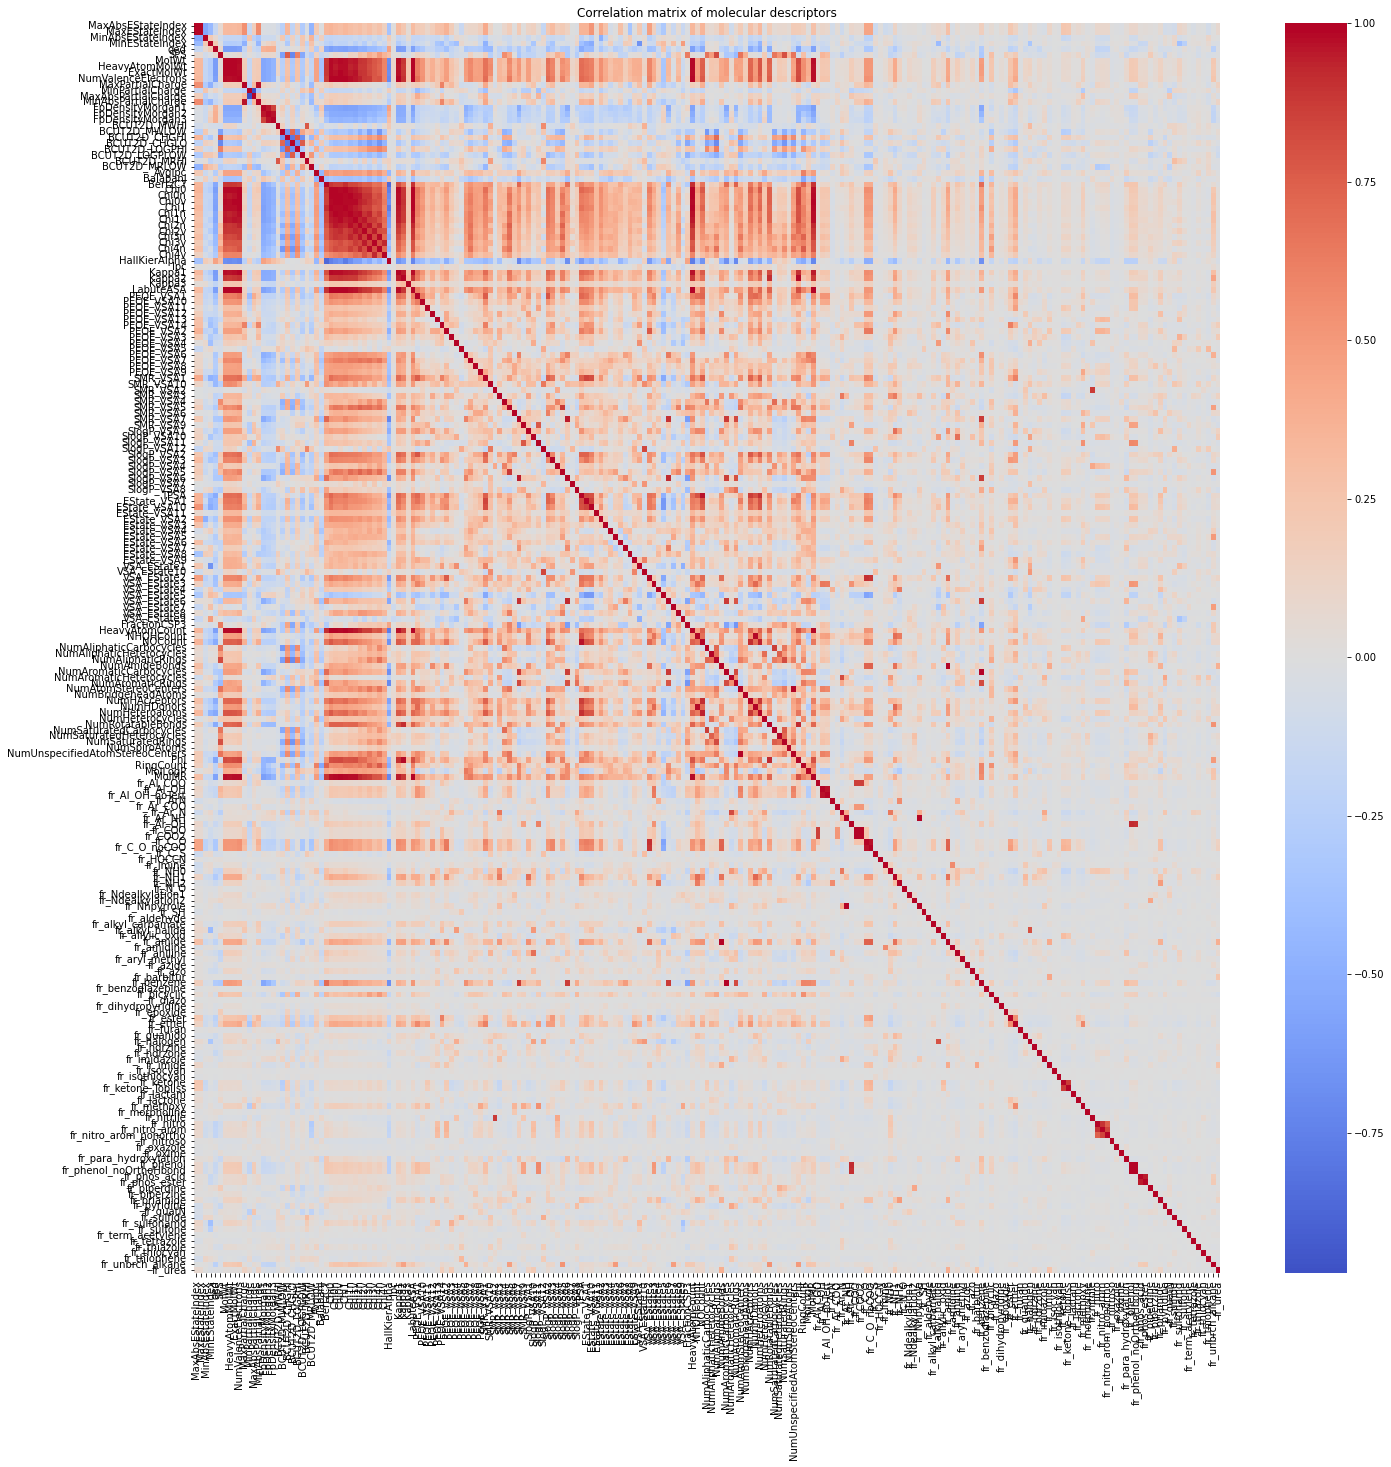

In [126]:
# make a heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(23,23))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, xticklabels=X.columns, yticklabels=X.columns)
plt.title('Correlation matrix of molecular descriptors')
plt.show()

In [127]:
# Remove highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.8)]


In [128]:
upper_tri

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
MaxAbsEStateIndex,NaN,1.0,-0.542781,-0.432065,-0.159450,0.065250,0.319553,0.324507,0.319849,0.337772,...,-0.092810,0.113268,0.069821,-0.002035,-0.047160,0.005268,-0.006722,-0.081215,-0.006264,0.073570
MaxEStateIndex,NaN,NaN,-0.542781,-0.432065,-0.159450,0.065250,0.319553,0.324507,0.319849,0.337772,...,-0.092810,0.113268,0.069821,-0.002035,-0.047160,0.005268,-0.006722,-0.081215,-0.006264,0.073570
MinAbsEStateIndex,NaN,NaN,NaN,0.199459,0.068379,-0.086184,-0.173699,-0.174157,-0.173767,-0.184460,...,0.092415,-0.078126,-0.034146,-0.002925,0.021985,0.012624,0.010806,0.109916,0.010361,-0.001790
MinEStateIndex,NaN,NaN,NaN,NaN,0.198973,-0.019951,-0.267154,-0.277104,-0.267312,-0.251570,...,0.100908,-0.379926,-0.244031,0.006815,0.022561,0.036800,0.010155,0.061444,-0.030574,-0.033427
qed,NaN,NaN,NaN,NaN,NaN,0.084702,-0.602383,-0.605064,-0.602443,-0.586322,...,-0.011351,-0.048166,0.035709,-0.026206,0.003365,-0.060546,-0.001052,0.023662,-0.224896,-0.021849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_thiazole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.003787,-0.013867,-0.021387,-0.012261
fr_thiocyan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000630,0.000461,-0.000272
fr_thiophene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006187,-0.017069
fr_unbrch_alkane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001604


In [129]:
to_drop

['MaxEStateIndex',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Kappa1',
 'Kappa2',
 'LabuteASA',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'EState_VSA1',
 'EState_VSA10',
 'VSA_EState10',
 'VSA_EState6',
 'HeavyAtomCount',
 'NOCount',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedRings',
 'NumUnspecifiedAtomStereoCenters',
 'Phi',
 'MolMR',
 'fr_Al_OH_noTert',
 'fr_Ar_N',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_Nhpyrrole',
 'fr_amide',
 'fr_benzene',
 'fr_ketone_Topliss',
 'fr_nitrile',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_phos_ester']

In [130]:
# drop the highly correlated features
X = X.drop(columns=to_drop)

In [131]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
2,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,0.227991,-0.278994,0.904762,32.166581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.401803,0.087790,-4.524487,0.357615,12.583333,370.408,0.294690,-0.398692,0.708333,32.241217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.857917,0.980324,-4.296481,0.538723,13.400000,190.198,0.265456,-0.285515,0.800000,32.243582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.095257,0.310361,-3.269722,0.790087,11.437500,263.661,0.432193,-0.292838,1.312500,35.495691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.261759,0.067130,-1.112870,0.610259,9.200000,138.122,0.338969,-0.507053,1.300000,16.367670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,13.370142,0.007185,-0.366239,0.804191,32.035714,379.504,0.253334,-0.357464,1.178571,16.195785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41123,14.160262,0.075082,-0.480928,0.427745,28.888889,484.596,0.243160,-0.453593,0.972222,16.696788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41124,13.962959,0.011372,-0.415582,0.450949,29.212121,440.587,0.243158,-0.357465,0.939394,16.182020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41125,13.989331,0.009754,-0.416314,0.450949,29.212121,440.587,0.243158,-0.357465,0.969697,16.182023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
# normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [133]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.384700,-0.625915,0.729836,0.277579,-0.527913,-0.436011,-0.432308,1.273904,-0.524627,0.286732,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
1,0.090784,-0.428024,-2.488228,-0.747159,-0.560540,0.041172,0.282648,0.161348,-1.214944,0.291132,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
2,-0.494572,3.346938,-2.327515,0.082308,-0.477643,-1.046894,-0.030714,1.213288,-0.892796,0.291271,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
3,0.353702,0.513337,-1.603785,1.233542,-0.676849,-0.603342,1.756557,1.145231,0.908304,0.482999,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
4,-0.341457,-0.515405,-0.083490,0.409936,-0.903969,-1.361317,0.757280,-0.845829,0.864375,-0.644691,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39451,0.837068,-0.768938,0.442786,1.298135,1.413999,0.096091,-0.160654,0.544551,0.437633,-0.654825,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39452,1.136637,-0.481769,0.361945,-0.425966,1.094576,0.730612,-0.269706,-0.348937,-0.287549,-0.625288,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39453,1.061831,-0.751231,0.408006,-0.319694,1.127386,0.464896,-0.269729,0.544543,-0.402918,-0.655636,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39454,1.071829,-0.758073,0.407490,-0.319694,1.127386,0.464896,-0.269727,0.544543,-0.296423,-0.655636,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422


# PCA analysis

In [134]:
# fit a PCA model
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.09865246 0.05873711]


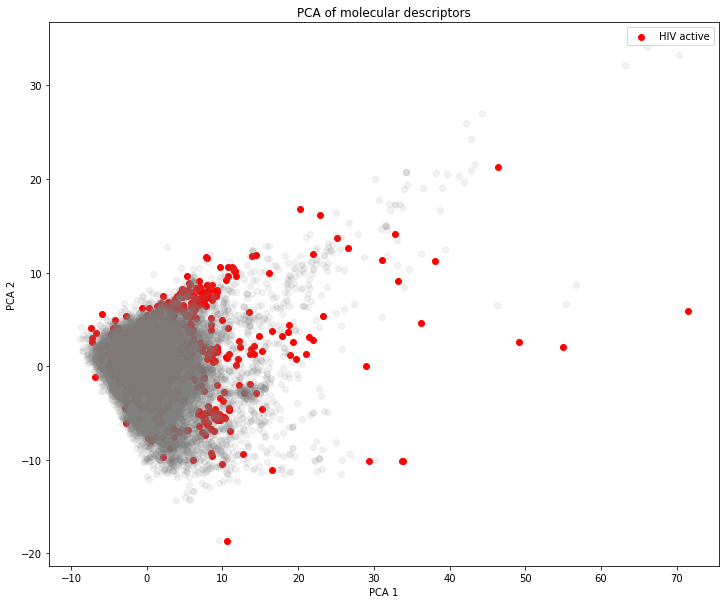

In [135]:
# plot the PCA result and color by the activity of each data point
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
# use class 1 only
X_pca_pos = X_pca[y==1]
X_pca_neg = X_pca[y==0]
plt.scatter(X_pca_pos[:,0], X_pca_pos[:,1], alpha= 1, c='red', label='HIV active')
plt.scatter(X_pca_neg[:,0], X_pca_neg[:,1], c='grey', alpha=0.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title('PCA of molecular descriptors')
plt.show()

# Feature selection

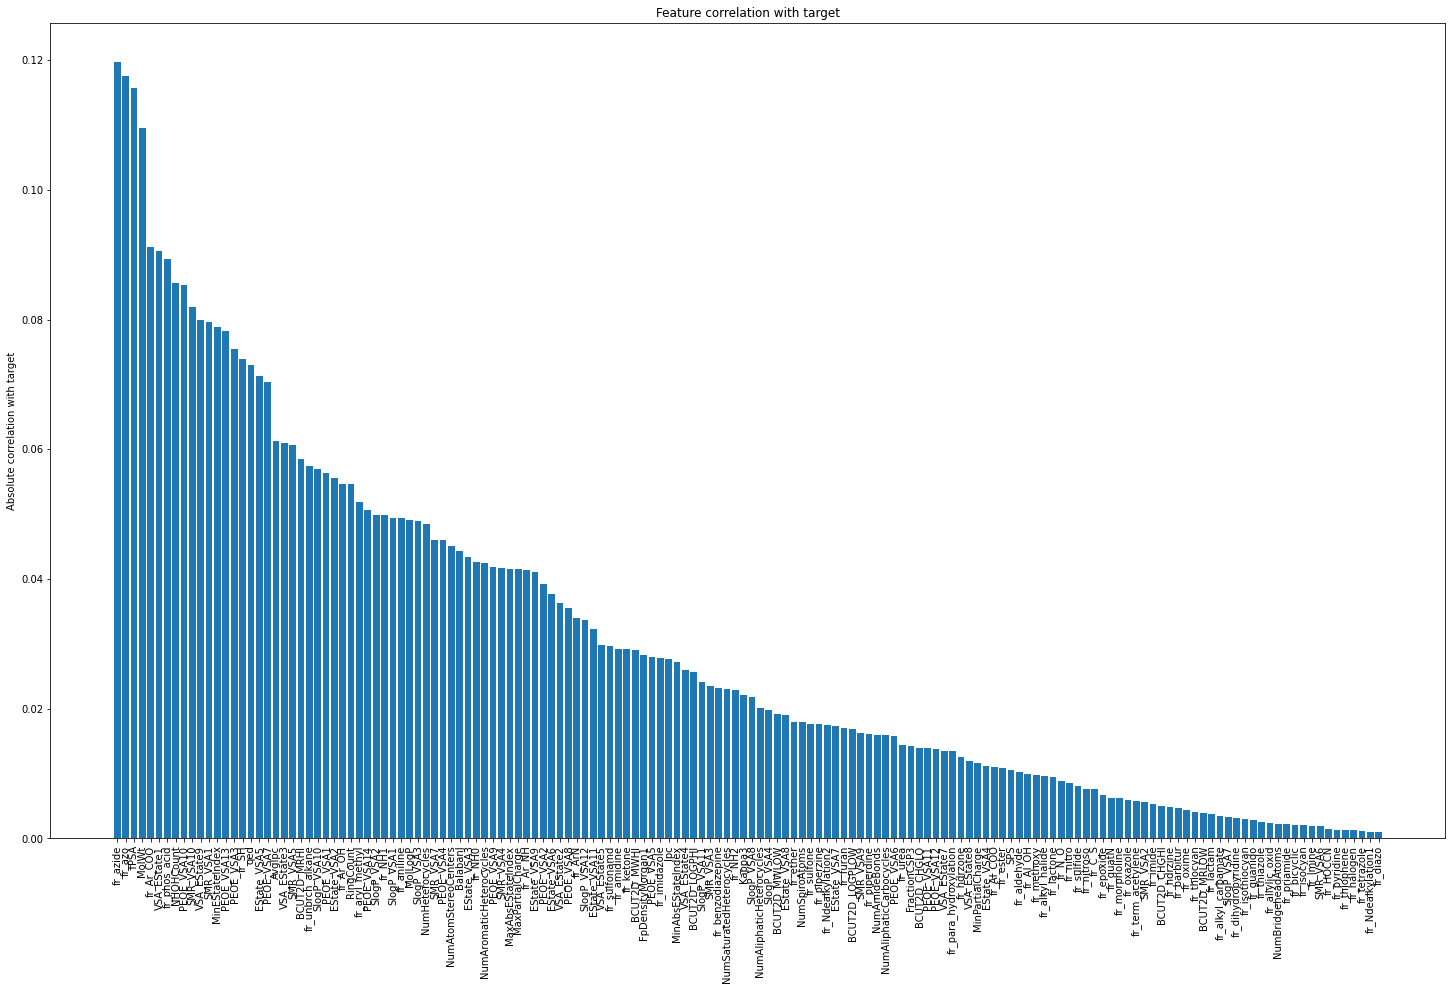

In [136]:
# plot the correlation of each feature with the target
import numpy as np
correlations = X.apply(lambda x: np.corrcoef(x, y)[0,1])
correlations = correlations.abs().sort_values(ascending=False)
plt.figure(figsize=(25,15))
plt.bar(correlations.index, correlations.values)
plt.xticks(rotation=90)
plt.ylabel('Absolute correlation with target')
plt.title('Feature correlation with target')
plt.show()

In [137]:
# 10 most correlated features with the target
corr_features = correlations.head(10)
corr_features

fr_azide        0.119721
fr_azo          0.117604
TPSA            0.115634
MolWt           0.109483
fr_Ar_COO       0.091130
VSA_EState1     0.090584
fr_phos_acid    0.089372
NHOHCount       0.085560
PEOE_VSA10      0.085393
SMR_VSA10       0.081942
dtype: float64

In [138]:
X_selected = X[corr_features.index].reset_index(drop=True)
y = y.reset_index(drop=True)

In [139]:
X_selected

,fr_azide,fr_azo,TPSA,MolWt,fr_Ar_COO,VSA_EState1,fr_phos_acid,NHOHCount,PEOE_VSA10,SMR_VSA10
0,-0.075285,-0.121837,-1.014813,-0.436011,-0.131099,-0.582145,-0.060594,-0.720073,-0.810142,0.787087
1,-0.075285,-0.121837,1.304390,0.041172,-0.131099,2.650434,-0.060594,1.893132,0.127752,1.004853
2,-0.075285,-0.121837,0.445193,-1.046894,-0.131099,2.211410,-0.060594,0.150995,-0.810142,-0.293250
3,-0.075285,-0.121837,-0.564907,-0.603342,-0.131099,0.541638,-0.060594,-0.284539,-0.810142,-0.028488
4,-0.075285,-0.121837,-0.400299,-1.361317,5.046710,-0.582145,-0.060594,0.150995,0.273546,-1.080436
...,...,...,...,...,...,...,...,...,...,...
39451,-0.075285,-0.121837,-0.418791,0.096091,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,-0.156358
39452,-0.075285,-0.121837,-0.167504,0.730612,-0.131099,-0.026946,-0.060594,-0.284539,-0.810142,0.157446
39453,-0.075285,-0.121837,-0.472284,0.464896,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,0.157446
39454,-0.075285,-0.121837,-0.472284,0.464896,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,0.157446


In [140]:
y

0        0
1        0
2        0
3        0
4        0
        ..
39451    0
39452    0
39453    0
39454    0
39455    0
Name: y, Length: 39456, dtype: int64

In [141]:
X_selected['HIV active'] = y

# Model Training

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [155]:
# construct a logistic regression model to predict HIV_active based on functional group counts

# randomly subsample the majority class to balance the dataset
min_size = y.value_counts().min() * 5
print('Size of class 1: ', min_size)
balanced_df = pd.concat([
    X_selected[X_selected['HIV active'] == 0].sample(min_size, random_state=42),
    X_selected[X_selected['HIV active'] == 1].sample(min_size, random_state=42, replace=True)
])


X_ = balanced_df.drop(columns=['HIV active'])
y_ = balanced_df['HIV active']


Size of class 1:  6300


In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# get the most important functional groups based on the logistic regression coefficients
importance = pd.DataFrame({'Functional_Group': X_selected.columns[:-1],
                           'Coefficient': model.coef_[0]})
importance = importance.sort_values(by='Coefficient', ascending=False)
print(importance.head(10))

[[987 291]
 [648 594]]
  Functional_Group  Coefficient
9        SMR_VSA10     0.250833
8       PEOE_VSA10     0.237271
0         fr_azide     0.223304
7        NHOHCount     0.202907
5      VSA_EState1     0.171888
4        fr_Ar_COO     0.138059
6     fr_phos_acid     0.126477
1           fr_azo     0.076716
2             TPSA    -0.061493
3            MolWt    -0.076279


              precision    recall  f1-score   support

           0       0.60      0.77      0.68      1278
           1       0.67      0.48      0.56      1242

    accuracy                           0.63      2520
   macro avg       0.64      0.63      0.62      2520
weighted avg       0.64      0.63      0.62      2520



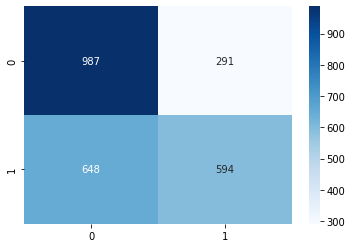

In [157]:
# confusion matrix and precision, recall, f1-score
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
print(classification_report(y_test, y_pred))


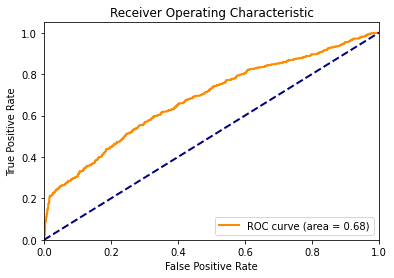

In [158]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [153]:
# find the best threshold for classification
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold: ', optimal_threshold)

# recal, precision, f1-score for the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

Optimal threshold:  0.5958870968118182
[[229  11]
 [184  80]]
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       240
           1       0.88      0.30      0.45       264

    accuracy                           0.61       504
   macro avg       0.72      0.63      0.58       504
weighted avg       0.72      0.61      0.57       504



In [151]:
# for steps of logreg iterations in range(10, 1000, 50): train a model and track the train f1 score and test f1 score

test_f1_scores = []
train_f1_scores = []

for steps in range(10, 1000, 50):
    model = LogisticRegression(max_iter=steps, penalty='elasticnet', solver='saga', l1_ratio=0.5)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    from sklearn.metrics import f1_score
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    print(f'Iterations: {steps}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iterations: 10, Train F1: 0.5346, Test F1: 0.5413
Iterations: 60, Train F1: 0.5538, Test F1: 0.5588
Iterations: 110, Train F1: 0.5538, Test F1: 0.5588
Iterations: 160, Train F1: 0.5538, Test F1: 0.5588
Iterations: 210, Train F1: 0.5538, Test F1: 0.5588
Iterations: 260, Train F1: 0.5538, Test F1: 0.5619
Iterations: 310, Train F1: 0.5538, Test F1: 0.5588
Iterations: 360, Train F1: 0.5538, Test F1: 0.5588
Iterations: 410, Train F1: 0.5538, Test F1: 0.5588
Iterations: 460, Train F1: 0.5538, Test F1: 0.5588
Iterations: 510, Train F1: 0.5538, Test F1: 0.5588
Iterations: 560, Train F1: 0.5538, Test F1: 0.5588
Iterations: 610, Train F1: 0.5538, Test F1: 0.5588
Iterations: 660, Train F1: 0.5538, Test F1: 0.5588
Iterations: 710, Train F1: 0.5538, Test F1: 0.5588
Iterations: 760, Train F1: 0.5538, Test F1: 0.5588
Iterations: 810, Train F1: 0.5538, Test F1: 0.5588
Iterations: 860, Train F1: 0.5538, Test F1: 0.5619
Iterations: 910, Train F1: 0.5538, Test F1: 0.5619
Iterations: 960, Train F1: 0.5538